# 🧬 Single-Cell RNA-seq Analysis with Scanpy

This notebook walks through a **complete single-cell RNA-seq (scRNA-seq)** data analysis pipeline using the Python package **Scanpy**.  
It is written for **beginners** in single-cell bioinformatics — especially those coming from a biology background.

We'll go step-by-step through:
1. Loading and preprocessing data  
2. Quality control (QC)  
3. Normalization and feature selection  
4. Dimensionality reduction (PCA, UMAP)  
5. Clustering  
6. Marker gene detection and visualization

By the end of this notebook, you’ll understand not only *how* to perform each step, but also *why* it’s important.

---


### 🧩 Loading Data
In this step, we load the single-cell expression matrix into an **AnnData** object — the core data structure in Scanpy.
It contains:
- `adata.X`: the expression matrix (cells × genes)
- `adata.obs`: metadata for each cell
- `adata.var`: metadata for each gene


In [1]:
#Import core single cell tools

import scanpy as sc
import anndata as ad
import duckdb
import pandas as pd

In [2]:
adata = sc.read_h5ad('bone_marrow.h5ad')

In [3]:
# the dimensions of our dataset
adata.shape

(14783, 17374)

In [4]:
# let's look at the first 5 rows describing the genes in our dataset
adata.var.head()

n_cells  feature_is_filtered feature_name feature_reference  \
ENSG00000161920      927                False        MED11    NCBITaxon:9606   
ENSG00000122335      429                False       SERAC1    NCBITaxon:9606   
ENSG00000175548      149                False       ALG10B    NCBITaxon:9606   
ENSG00000100330      426                False        MTMR3    NCBITaxon:9606   
ENSG00000176340     7171                False        COX8A    NCBITaxon:9606   

                feature_biotype feature_length    feature_type  
ENSG00000161920            gene            754  protein_coding  
ENSG00000122335            gene           2683  protein_coding  
ENSG00000175548            gene           1773  protein_coding  
ENSG00000100330            gene            634  protein_coding  
ENSG00000176340            gene            494  protein_coding

In [5]:
# let's look at the first 5 rows describing the cells (ID) in our dataset
adata.obs.columns

Index(['disease stage', 'treatment', 'timepoint', 'Dataset', 'sample',
       'disease_original', 'disease_general', 'COVID-19 Condition', 'Lineage',
       'Cell.group', 'Cell.class_reannotated', 'n_genes', 'n_counts',
       'percent_mito', 'tissue_original', 'tissue_ontology_term_id',
       'disease_ontology_term_id', 'donor_id',
       'development_stage_ontology_term_id', 'assay_ontology_term_id',
       'cell_type_ontology_term_id',
       'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id',
       'is_primary_data', 'suspension_type', 'tissue_type', 'assay', 'disease',
       'sex', 'tissue', 'self_reported_ethnicity', 'development_stage',
       'observation_joinid'],
      dtype='object')

### 🧹 Quality Control (QC)
QC ensures we only keep high-quality cells and informative genes.
Typical filters remove:
- Harmonize unique gene names (avoid gene duplications from old pipelines)
- Cells with too few genes (likely dead)
- Cells with too many genes (possible doublets)
- Genes expressed in very few cells (uninformative)


In [6]:
# A useful step for older datasets
adata.var_names_make_unique()
adata.obs_names_make_unique()

In [7]:
adata.var

n_cells  feature_is_filtered     feature_name  \
ENSG00000161920      927                False            MED11   
ENSG00000122335      429                False           SERAC1   
ENSG00000175548      149                False           ALG10B   
ENSG00000100330      426                False            MTMR3   
ENSG00000176340     7171                False            COX8A   
...                  ...                  ...              ...   
ENSG00000176946      559                False            THAP4   
ENSG00000150456      289                False        EEF1AKMT1   
ENSG00000284934       11                False  ENSG00000284934   
ENSG00000261842        8                False  ENSG00000261842   
ENSG00000260456      132                False         C16orf95   

                feature_reference feature_biotype feature_length  \
ENSG00000161920    NCBITaxon:9606            gene            754   
ENSG00000122335    NCBITaxon:9606            gene           2683   
ENSG00000175548    NCBITaxon:9606            gene           1773   
ENSG00000100330    NCBITaxon:9606            gene            634   
ENSG00000176340    NCBITaxon:9606            gene            494   
...                           ...             ...            ...   
ENSG00000176946    NCBITaxon:9606            gene            785   
ENSG00000150456    NCBITaxon:9606            gene            875   
ENSG00000284934    NCBITaxon:9606            gene            560   
ENSG00000261842    NCBITaxon:9606            gene           2216   
ENSG00000260456    NCBITaxon:9606            gene            953   

                   feature_type  
ENSG00000161920  protein_coding  
ENSG00000122335  protein_coding  
ENSG00000175548  protein_coding  
ENSG00000100330  protein_coding  
ENSG00000176340  protein_coding  
...                         ...  
ENSG00000176946  protein_coding  
ENSG00000150456  protein_coding  
ENSG00000284934  protein_coding  
ENSG00000261842          lncRNA  
ENSG00000260456  protein_coding  

[17374 rows x 7 columns]

In [8]:
#Let's search for possible contamination from dying cells, ribosomal transcripts or hemoglobin

#Cells with a high proportion of mitochondrial reads (say >10–20%) are likely stressed, apoptotic, or poorly captured
#Ribosomal transcripts are removed because they represent global transcriptional activity, not cell-type-specific biology
#Instead of true cell populations, high HB signal often represents ambient RNA contamination from lysed red blood cells

adata.var['MT'] = adata.var['feature_name'].str.startswith("MT-")
adata.var['RIBO'] = adata.var['feature_name'].str.startswith(("RPS", "RPL"))
adata.var['HB'] = adata.var['feature_name'].str.startswith("^HB[^(P)]")

In [9]:
#let's just take a quick look at one of them.

mt_genes = adata.var[adata.var['MT']]
mt_genes

n_cells  feature_is_filtered feature_name feature_reference  \
ENSG00000228253     2270                False      MT-ATP8    NCBITaxon:9606   
ENSG00000198899    15626                False      MT-ATP6    NCBITaxon:9606   
ENSG00000198763    15561                False       MT-ND2    NCBITaxon:9606   
ENSG00000198886    15656                False       MT-ND4    NCBITaxon:9606   
ENSG00000198804    15656                False       MT-CO1    NCBITaxon:9606   
ENSG00000198695     4611                False       MT-ND6    NCBITaxon:9606   
ENSG00000212907     6575                False      MT-ND4L    NCBITaxon:9606   
ENSG00000198888    14520                False       MT-ND1    NCBITaxon:9606   
ENSG00000198712    15669                False       MT-CO2    NCBITaxon:9606   
ENSG00000198727    15393                False       MT-CYB    NCBITaxon:9606   
ENSG00000198938    15694                False       MT-CO3    NCBITaxon:9606   
ENSG00000198840    15386                False       MT-ND3    NCBITaxon:9606   
ENSG00000198786    13615                False       MT-ND5    NCBITaxon:9606   

                feature_biotype feature_length    feature_type    MT   RIBO  \
ENSG00000228253            gene            207  protein_coding  True  False   
ENSG00000198899            gene            681  protein_coding  True  False   
ENSG00000198763            gene           1042  protein_coding  True  False   
ENSG00000198886            gene           1378  protein_coding  True  False   
ENSG00000198804            gene           1542  protein_coding  True  False   
ENSG00000198695            gene            525  protein_coding  True  False   
ENSG00000212907            gene            297  protein_coding  True  False   
ENSG00000198888            gene            956  protein_coding  True  False   
ENSG00000198712            gene            684  protein_coding  True  False   
ENSG00000198727            gene           1141  protein_coding  True  False   
ENSG00000198938            gene            784  protein_coding  True  False   
ENSG00000198840            gene            346  protein_coding  True  False   
ENSG00000198786            gene           1812  protein_coding  True  False   

                    HB  
ENSG00000228253  False  
ENSG00000198899  False  
ENSG00000198763  False  
ENSG00000198886  False  
ENSG00000198804  False  
ENSG00000198695  False  
ENSG00000212907  False  
ENSG00000198888  False  
ENSG00000198712  False  
ENSG00000198727  False  
ENSG00000198938  False  
ENSG00000198840  False  
ENSG00000198786  False

In [10]:
#calculate the qc metrics. qc nnti akan nampak kat obs and var
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["MT", 'RIBO', 'HB'], inplace=True, log1p=True
)

In [11]:
#note that it is also included in the headers of obs

adata.obs.head()

disease stage                    treatment timepoint  \
index                                                                         
Guo-AAACCTGAGAGCTTCT-2        severe  400 mg Tocilizumab at day 1     day 1   
Guo-AAACCTGAGAGGTTGC-7     remission  400 mg Tocilizumab at day 1     day 7   
Guo-AAACCTGAGATACACA-3     remission  400 mg Tocilizumab at day 1     day 5   
Guo-AAACCTGAGCGATTCT-1        severe  400 mg Tocilizumab at day 1     day 1   
Guo-AAACCTGAGTGAAGAG-3     remission  400 mg Tocilizumab at day 1     day 5   

                                                Dataset            sample  \
index                                                                       
Guo-AAACCTGAGAGCTTCT-2  Guo et al._Nature Communication  Guo_P1-day1-rep2   
Guo-AAACCTGAGAGGTTGC-7  Guo et al._Nature Communication       Guo_P2-day7   
Guo-AAACCTGAGATACACA-3  Guo et al._Nature Communication  Guo_P1-day5-rep1   
Guo-AAACCTGAGCGATTCT-1  Guo et al._Nature Communication  Guo_P1-day1-rep1   
Guo-AAACCTGAGTGAAGAG-3  Guo et al._Nature Communication  Guo_P1-day5-rep1   

                               disease_original  \
index                                             
Guo-AAACCTGAGAGCTTCT-2          COVID-19 Severe   
Guo-AAACCTGAGAGGTTGC-7  COVID-19 Mild/Remission   
Guo-AAACCTGAGATACACA-3  COVID-19 Mild/Remission   
Guo-AAACCTGAGCGATTCT-1          COVID-19 Severe   
Guo-AAACCTGAGTGAAGAG-3  COVID-19 Mild/Remission   

                                        disease_general COVID-19 Condition  \
index                                                                        
Guo-AAACCTGAGAGCTTCT-2  COVID-19 Severe/Late stage/Vent             severe   
Guo-AAACCTGAGAGGTTGC-7               COVID-19 Remission          remission   
Guo-AAACCTGAGATACACA-3               COVID-19 Remission          remission   
Guo-AAACCTGAGCGATTCT-1  COVID-19 Severe/Late stage/Vent             severe   
Guo-AAACCTGAGTGAAGAG-3               COVID-19 Remission          remission   

                              Lineage      Cell.group  ...  \
index                                                  ...   
Guo-AAACCTGAGAGCTTCT-2        Myeloid  CD14+ Monocyte  ...   
Guo-AAACCTGAGAGGTTGC-7  Lymphoid_T/NK     CD8+ T cell  ...   
Guo-AAACCTGAGATACACA-3  Lymphoid_T/NK     CD4+ T cell  ...   
Guo-AAACCTGAGCGATTCT-1  Lymphoid_T/NK     CD8+ T cell  ...   
Guo-AAACCTGAGTGAAGAG-3  Lymphoid_T/NK     CD4+ T cell  ...   

                       pct_counts_in_top_500_genes  total_counts_MT  \
index                                                                 
Guo-AAACCTGAGAGCTTCT-2                   40.537370       138.356339   
Guo-AAACCTGAGAGGTTGC-7                   57.850376       113.859787   
Guo-AAACCTGAGATACACA-3                   59.749640       125.068520   
Guo-AAACCTGAGCGATTCT-1                   56.156243       103.474380   
Guo-AAACCTGAGTGAAGAG-3                  100.000121       138.531082   

                        log1p_total_counts_MT  pct_counts_MT  \
index                                                          
Guo-AAACCTGAGAGCTTCT-2               4.937034       1.154665   
Guo-AAACCTGAGAGGTTGC-7               4.743712       1.350507   
Guo-AAACCTGAGATACACA-3               4.836825       1.543431   
Guo-AAACCTGAGCGATTCT-1               4.648942       1.182754   
Guo-AAACCTGAGTGAAGAG-3               4.938287       2.870118   

                       total_counts_RIBO log1p_total_counts_RIBO  \
index                                                              
Guo-AAACCTGAGAGCTTCT-2        879.968079                6.781022   
Guo-AAACCTGAGAGGTTGC-7        914.212402                6.819156   
Guo-AAACCTGAGATACACA-3        952.813843                6.860468   
Guo-AAACCTGAGCGATTCT-1        924.013672                6.829809   
Guo-AAACCTGAGTGAAGAG-3        850.272156                6.746732   

                       pct_counts_RIBO total_counts_HB log1p_total_counts_HB  \
index                                                                          
Guo-A

In [12]:
#and your gene list
adata.var.head()

n_cells  feature_is_filtered feature_name feature_reference  \
ENSG00000161920      927                False        MED11    NCBITaxon:9606   
ENSG00000122335      429                False       SERAC1    NCBITaxon:9606   
ENSG00000175548      149                False       ALG10B    NCBITaxon:9606   
ENSG00000100330      426                False        MTMR3    NCBITaxon:9606   
ENSG00000176340     7171                False        COX8A    NCBITaxon:9606   

                feature_biotype feature_length    feature_type     MT   RIBO  \
ENSG00000161920            gene            754  protein_coding  False  False   
ENSG00000122335            gene           2683  protein_coding  False  False   
ENSG00000175548            gene           1773  protein_coding  False  False   
ENSG00000100330            gene            634  protein_coding  False  False   
ENSG00000176340            gene            494  protein_coding  False  False   

                    HB  n_cells_by_counts  mean_counts  log1p_mean_counts  \
ENSG00000161920  False                885     0.502831           0.407351   
ENSG00000122335  False                405     0.231814           0.208488   
ENSG00000175548  False                142     0.082084           0.078889   
ENSG00000100330  False                404     0.227307           0.204822   
ENSG00000176340  False               6898     4.277597           1.663471   

                 pct_dropout_by_counts  total_counts  log1p_total_counts  
ENSG00000161920              94.013394   7433.353516            8.913867  
ENSG00000122335              97.260367   3426.911377            8.139707  
ENSG00000175548              99.039437   1213.443970            7.102042  
ENSG00000100330              97.267131   3360.278564            8.120077  
ENSG00000176340              53.338294  63235.750000           11.054641

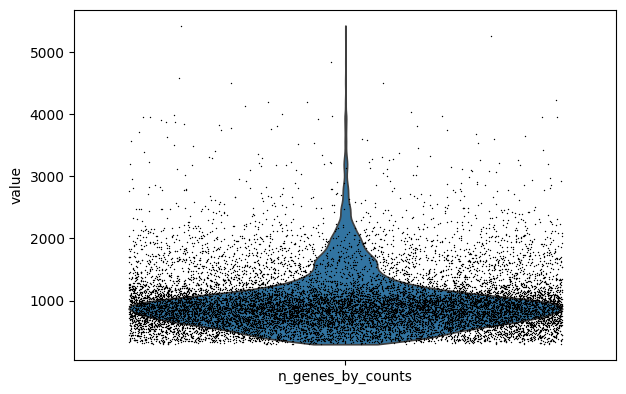

In [13]:
#what is the average number of genes that have at least one detected identifier in each cell.
#in other words, the number of genes expressed in each cell

sc.pl.violin(
    adata,
    ["n_genes_by_counts"],
    jitter=0.4,
    multi_panel=False,
)

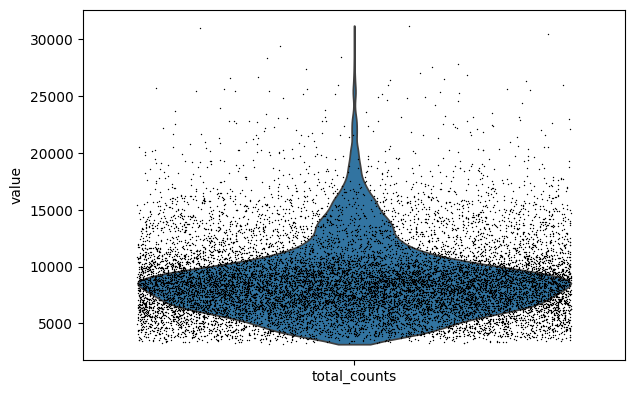

In [14]:
#What is the total number of molecules (UMI) detected in a cell.
#basically you can have 10 UMI molecules but they are all pointing to the same gene.

sc.pl.violin(
    adata,
    ["total_counts"],
    jitter=0.4,
    multi_panel=False,
)

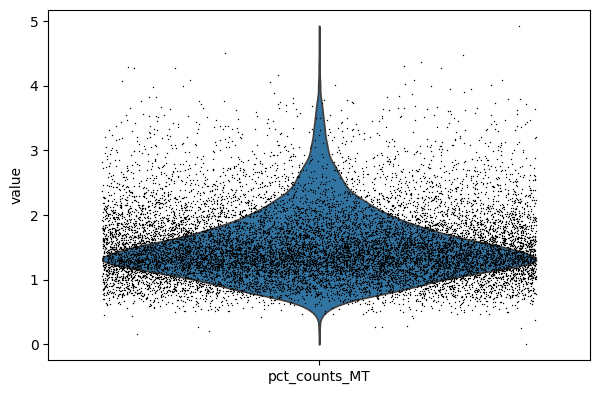

In [15]:
#what about those mitochondrial genes?
sc.pl.violin(
    adata,
    ["pct_counts_MT"],
    jitter=0.4,
    multi_panel=False,
)

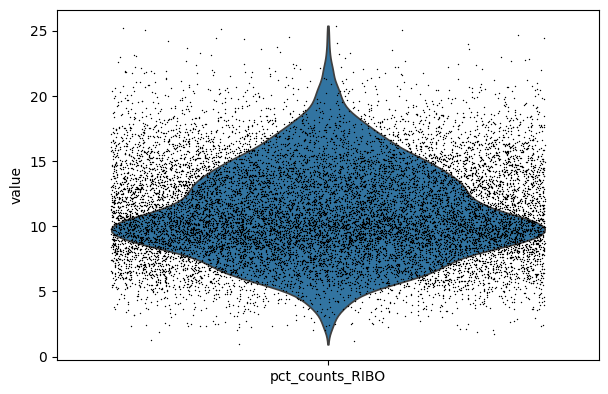

In [16]:
#and the ribosomal genes
sc.pl.violin(
    adata,
    ["pct_counts_RIBO"],
    jitter=0.4,
    multi_panel=False,
)

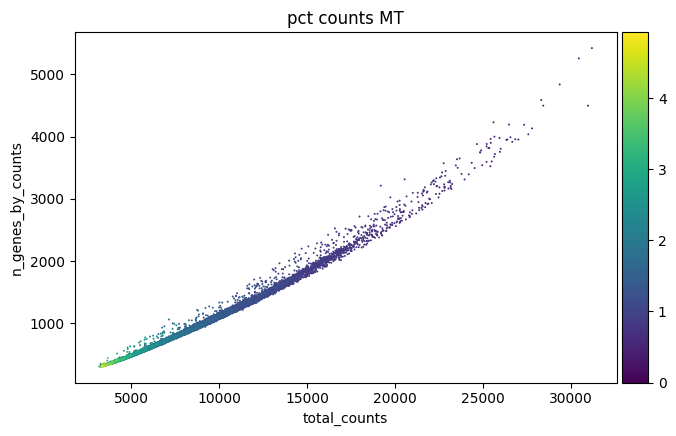

In [17]:
#let's visualize the three of them. And let's see where the mitochondrial genes are
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_MT")

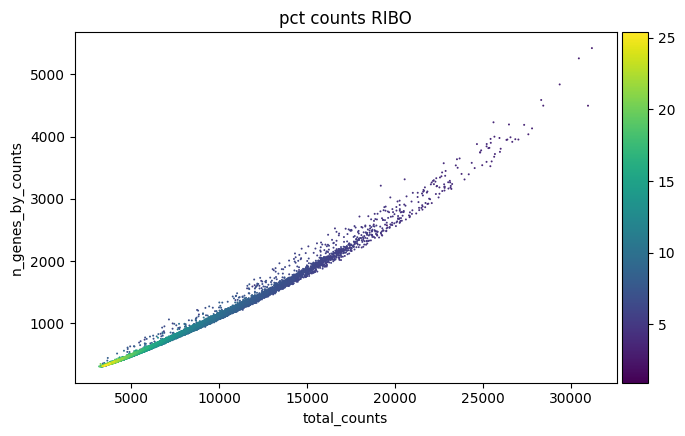

In [18]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_RIBO")

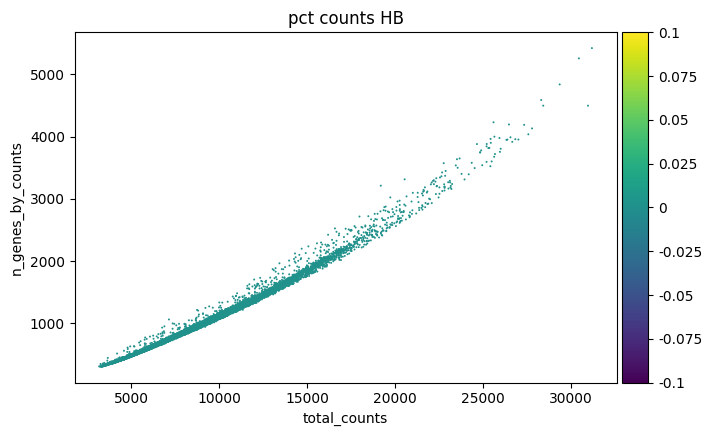

In [19]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_HB")

Additionally, it is important to note that for datasets with multiple batches, quality control should be performed for each sample individually as quality control thresholds can vary substantially between batches.

In [20]:
#Let's use the data MT plot to select things to remove
sc.pp.filter_cells(adata, min_genes=1000)
sc.pp.filter_genes(adata, min_cells=1000)

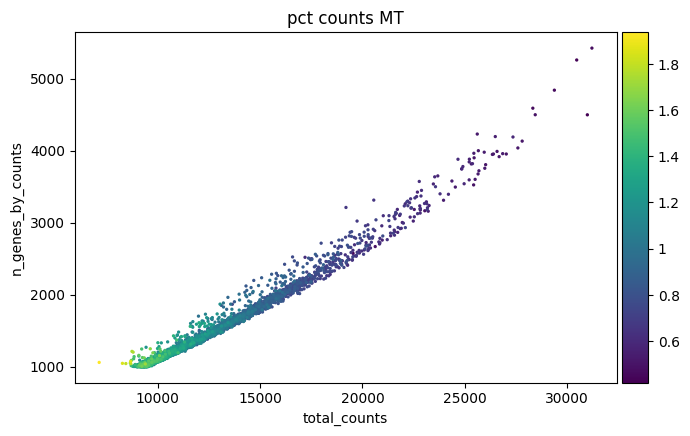

In [21]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_MT")

In [22]:
# we can also further filter for ribosomal contaminations using

adata = adata[
    adata.obs['pct_counts_RIBO'] < 10,
    :
]


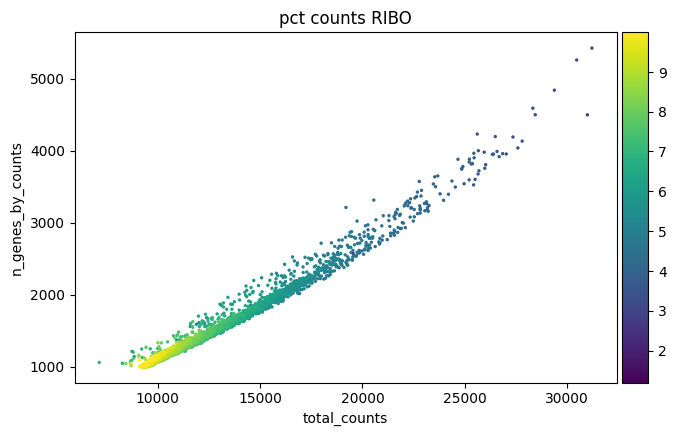

In [23]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_RIBO")

### Doublet detection
Identifying doublets is crucial as they can lead to misclassifications or distortions in downstream analysis steps

In [24]:
sc.pp.scrublet(adata) #if you have multiple batch samples, you can specify it with batch_key="sample"

/home/sepanjibu/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_scrublet/__init__.py:295: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["doublet_score"] = scrubbed["obs"]["doublet_score"]


### ⚖️ Normalization
Normalization adjusts for sequencing depth differences between cells.
Here, we scale counts so each cell has the same total expression level.

In [25]:
# Save a copy of the data
adata.layers["counts"] = adata.X.copy()

In [26]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

In [27]:
#Feature selection
#selecting the top 1000 most variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=1000)

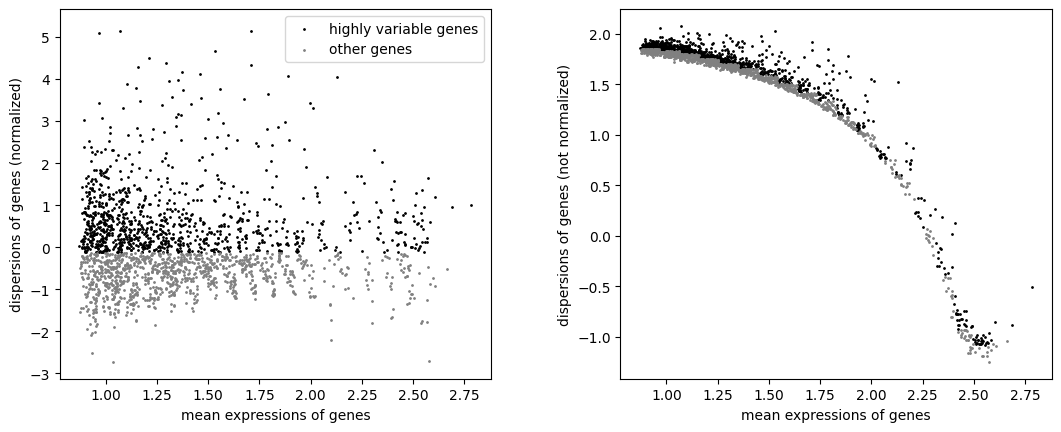

In [28]:
sc.pl.highly_variable_genes(adata )
#left is normalized
#right is not

### 🔍 Dimensionality Reduction (PCA)
We use **Principal Component Analysis (PCA)** to reduce data complexity and highlight key variation patterns.
This makes later steps like clustering and visualization faster and more robust.

In single-cell RNA-seq, each cell has expression values for thousands of genes, creating a huge, noisy matrix. PCA compresses this high-dimensional data into a smaller set of features (typically 30–50 components) that summarize the key biological and technical variation across cells.

- Noise reduction: scRNA-seq data are sparse and noisy. PCA focuses on the strongest correlated gene expression patterns, discarding random noise.

- Computational efficiency: Downstream analyses like clustering, UMAP, or t-SNE run much faster and more robustly on 30 PCs than on 20,000 genes.

- Signal extraction: The top PCs often correspond to meaningful biological structure—cell type, cell cycle state, or activation level—while later PCs capture less relevant variation.

In [29]:
sc.tl.pca(adata)

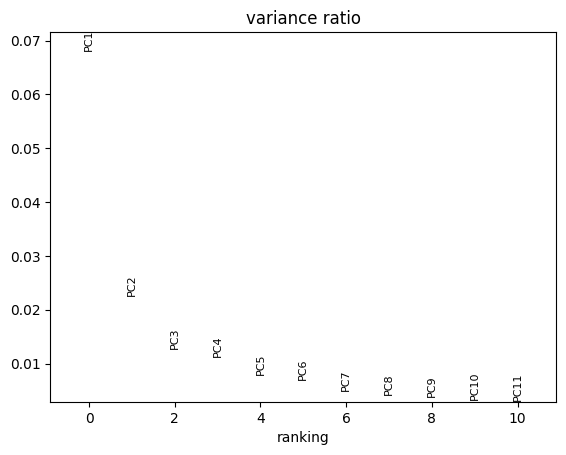

In [30]:
sc.pl.pca_variance_ratio(adata, n_pcs=10, log=False)

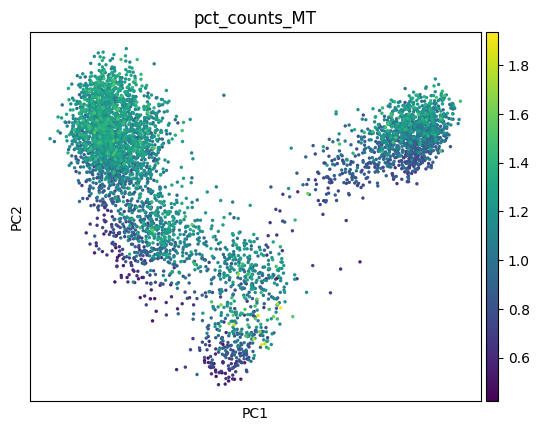

In [31]:
sc.pl.pca(
    adata,
    color=["pct_counts_MT"]
)

## Nearest Neighbour
Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. Basically we want to cluster the PCA components

In [32]:
sc.pp.neighbors(adata)

In [33]:
sc.tl.umap(adata)

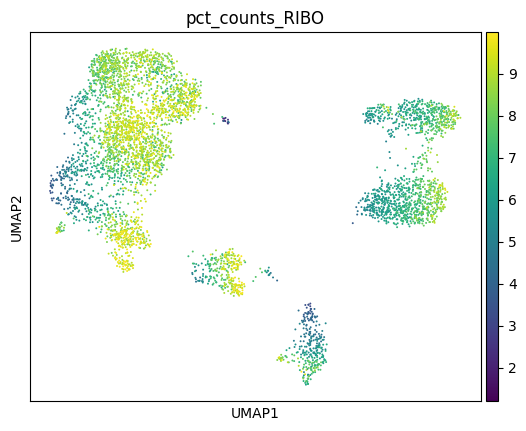

In [34]:
sc.pl.umap(
    adata,
    color=["pct_counts_RIBO"],
    size=8,
)

## Clustering by communities
Clustering by communities in single-cell RNA-seq is the process of grouping cells that show similar expression profiles — essentially, discovering putative cell types or states. Once PCA compresses your data into a manageable set of dimensions, clustering algorithms like Leiden operate on a graph-based representation of cell–cell relationships. Usually used for cell type detection

In [35]:
# Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets
sc.tl.leiden(adata, flavor="igraph", n_iterations=2)

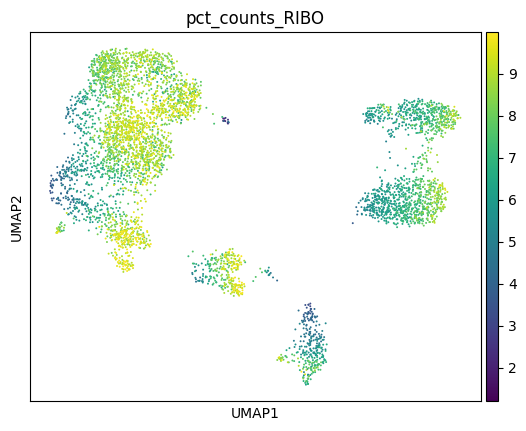

In [36]:
sc.pl.umap(
    adata,
    color=["pct_counts_RIBO"],
    size=8,
)

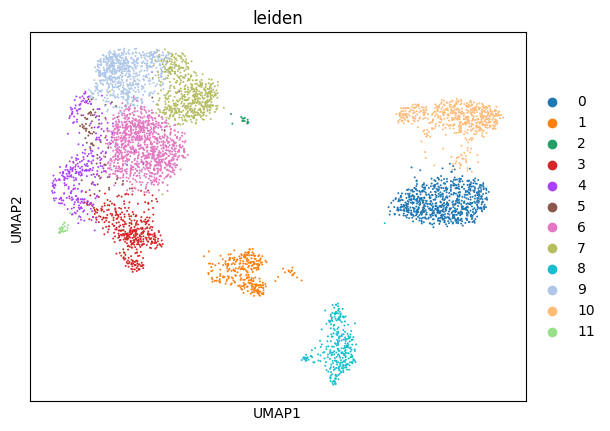

In [37]:
sc.pl.umap(
    adata,
    color=["leiden"],
    size=8,
)

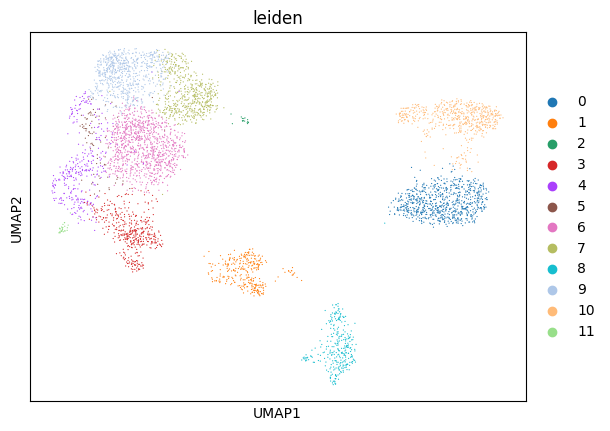

In [38]:
sc.pl.umap(
    adata,
    color=["leiden"],
    # increase horizontal space between panels
    wspace=0.5,
    size=3,
    ncols = 1
)

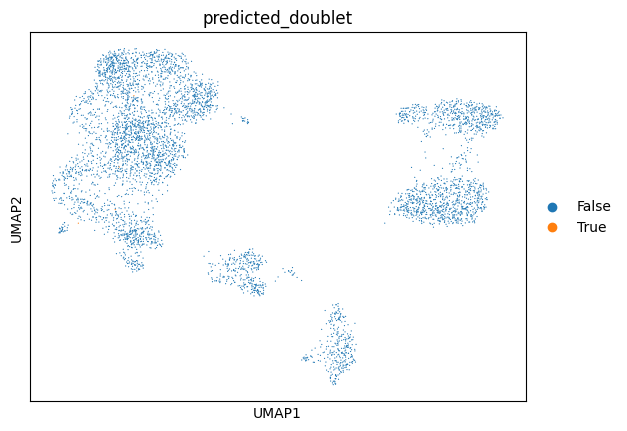

In [39]:
sc.pl.umap(
    adata,
    color=[ "predicted_doublet"],
    # increase horizontal space between panels
    wspace=0.5,
    size=3,
    ncols = 1
)

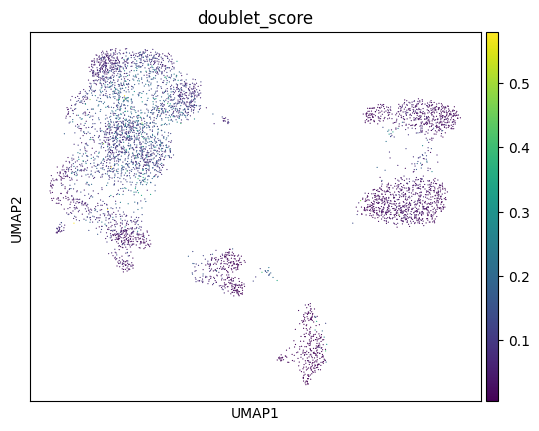

In [40]:
sc.pl.umap(
    adata,
    color=[ "doublet_score"],
    # increase horizontal space between panels
    wspace=0.5,
    size=3,
    ncols = 1
)

## Further reclustering

In [41]:
sc.tl.leiden(adata, flavor="igraph", n_iterations=2, key_added="leiden_res0_02", resolution=0.02)
sc.tl.leiden(adata, flavor="igraph", n_iterations=2, key_added="leiden_res0_5", resolution=0.5)
sc.tl.leiden(adata, flavor="igraph", n_iterations=2, key_added="leiden_res2", resolution=2)

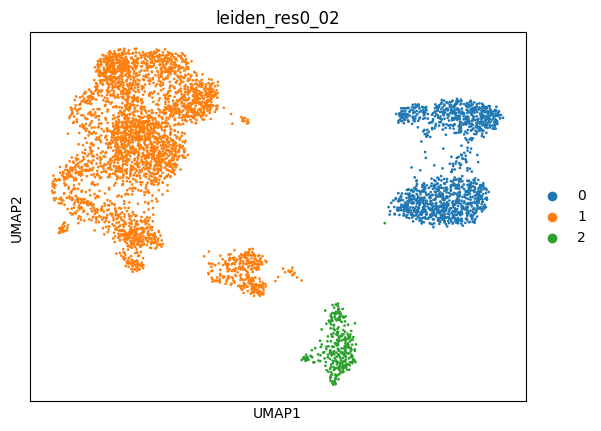

In [42]:
sc.pl.umap(
    adata,
    color=["leiden_res0_02"],
    # increase horizontal space between panels
    wspace=0.5,
    size=15,
    ncols = 1
)

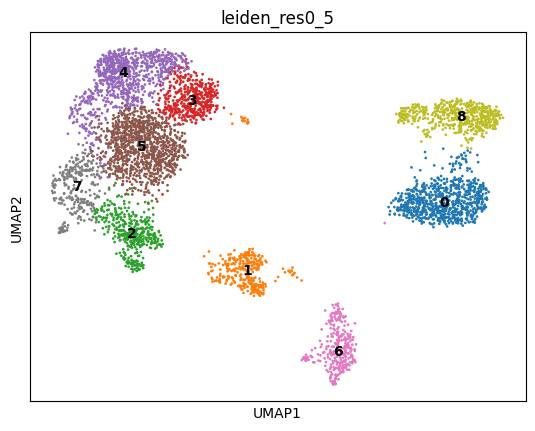

In [43]:
sc.pl.umap(
    adata,
    color=["leiden_res0_5"],
    # increase horizontal space between panels
    wspace=0.5,
    size=15,
    ncols = 1,
    legend_loc="on data"
)

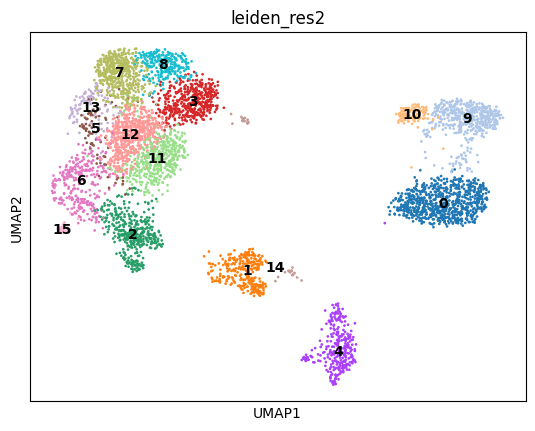

In [44]:
sc.pl.umap(
    adata,
    color=["leiden_res2"],
    # increase horizontal space between panels
    wspace=0.5,
    size=15,
    ncols = 1,
    legend_loc="on data"
)

### Cell Annotation
Cell annotation is the process of assigning biological meaning—like cell type or functional state—to each cluster found after Leiden clustering.

Traditionally, this relies on manual marker gene inspection: you identify top genes per cluster and match them to known markers. But tools like Decoupler enable a more systematic and data-driven approach.


Decoupler is a framework for gene set activity inference. Instead of labeling clusters by single markers, it estimates the activity of predefined pathways, transcription factors, or cell-type signatures from known databases (e.g., MSigDB, PROGENy, DoRothEA).

In practice:

- You provide your normalized expression matrix (adata).

- You load gene sets representing known biological programs or cell-type signatures.

- Decoupler calculates an activity score per cell or cluster using methods like weighted mean, ULM, or AUCell.

- You interpret those activities to annotate clusters automatically or semi-automatically.

In [45]:
import decoupler as dc

In [49]:
!wget -O result.txt 'http://www.ensembl.org/biomart/martservice?query=<?xml version="1.0" encoding="UTF-8"?><!DOCTYPE Query><Query  virtualSchemaName = "default" formatter = "CSV" header = "0" uniqueRows = "0" count = "" datasetConfigVersion = "0.6" ><Dataset name = "hsapiens_gene_ensembl" interface = "default" ><Attribute name = "ensembl_gene_id" /><Attribute name = "external_gene_name" /></Dataset></Query>'
#this downloads the table of genes directly from ensemble

--2025-11-20 21:55:41--  http://www.ensembl.org/biomart/martservice?query=%3C?xml%20version=%221.0%22%20encoding=%22UTF-8%22?%3E%3C!DOCTYPE%20Query%3E%3CQuery%20%20virtualSchemaName%20=%20%22default%22%20formatter%20=%20%22CSV%22%20header%20=%20%220%22%20uniqueRows%20=%20%220%22%20count%20=%20%22%22%20datasetConfigVersion%20=%20%220.6%22%20%3E%3CDataset%20name%20=%20%22hsapiens_gene_ensembl%22%20interface%20=%20%22default%22%20%3E%3CAttribute%20name%20=%20%22ensembl_gene_id%22%20/%3E%3CAttribute%20name%20=%20%22external_gene_name%22%20/%3E%3C/Dataset%3E%3C/Query%3E
Resolving www.ensembl.org (www.ensembl.org)... 193.62.193.83
Connecting to www.ensembl.org (www.ensembl.org)|193.62.193.83|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘result.txt’

result.txt              [   <=>              ]   1.71M  4.23MB/s    in 0.4s    

2025-11-20 21:55:46 (4.23 MB/s) - ‘result.txt’ saved [1795328]



In [51]:
import pandas as pd
ensembl_var = pd.read_csv('result.txt', header = None)
ensembl_var.columns = ['ensembl_gene_id', 'gene_name']
ensembl_var.head(3)

ensembl_gene_id gene_name
0  ENSG00000210049     MT-TF
1  ENSG00000211459   MT-RNR1
2  ENSG00000210077     MT-TV

In [46]:
# Query Omnipath and get PanglaoDB
markers = dc.op.resource(name="PanglaoDB", organism="human")

# Keep canonical cell type markers alone
markers = markers[markers["canonical_marker"]]

# Remove duplicated entries
markers = markers[~markers.duplicated(["cell_type", "genesymbol"])]

# Format because dc only accepts cell_type and genesymbol

markers = markers.rename(columns={"cell_type": "source", "genesymbol": "target"})
markers = markers[["source", "target"]]


markers.head()

source  target
                               
2         Bergmann glia     A2M
4            Mast cells  A4GALT
5  Embryonic stem cells  A7KBS4
8          Pinealocytes   AANAT
9            Astrocytes   AANAT

In [52]:
#correct target to ensemble
markers = markers.merge(ensembl_var, left_on="target", right_on="gene_name", how="left")
markers = markers.drop(columns=["target"])

# Remove duplicated entries
markers = markers[~markers.duplicated(["source", "ensembl_gene_id"])]

#Format because dc only accepts cell_type and genesymbol
markers = markers.rename(columns={"source": "source", "ensembl_gene_id": "target"})
markers = markers[["source", "target"]]
markers = markers.dropna()

markers.head()

source           target
0  Bergmann glia  ENSG00000175899
1     Mast cells  ENSG00000128274
3   Pinealocytes  ENSG00000129673
4     Astrocytes  ENSG00000129673
5  Sertoli cells  ENSG00000205002

In [53]:
adata.var

n_cells  feature_is_filtered feature_name feature_reference  \
ENSG00000176340     3761                False        COX8A    NCBITaxon:9606   
ENSG00000120616     2015                False         EPC1    NCBITaxon:9606   
ENSG00000119707     2751                False        RBM25    NCBITaxon:9606   
ENSG00000170571     1681                False          EMB    NCBITaxon:9606   
ENSG00000161671     1590                False        EMC10    NCBITaxon:9606   
...                  ...                  ...          ...               ...   
ENSG00000106682     1516                False        EIF4H    NCBITaxon:9606   
ENSG00000271869     1129                False     DCTN6-DT    NCBITaxon:9606   
ENSG00000182054     1809                False         IDH2    NCBITaxon:9606   
ENSG00000081154     1709                False         PCNP    NCBITaxon:9606   
ENSG00000151702     1335                False         FLI1    NCBITaxon:9606   

                feature_biotype feature_length    feature_type     MT   RIBO  \
ENSG00000176340            gene            494  protein_coding  False  False   
ENSG00000120616            gene           2656  protein_coding  False  False   
ENSG00000119707            gene           2018  protein_coding  False  False   
ENSG00000170571            gene           1617  protein_coding  False  False   
ENSG00000161671            gene           1768  protein_coding  False  False   
...                         ...            ...             ...    ...    ...   
ENSG00000106682            gene           2533  protein_coding  False  False   
ENSG00000271869            gene            806          lncRNA  False  False   
ENSG00000182054            gene           1451  protein_coding  False  False   
ENSG00000081154            gene            778  protein_coding  False  False   
ENSG00000151702            gene           3278  protein_coding  False  False   

                    HB  n_cells_by_counts  mean_counts  log1p_mean_counts  \
ENSG00000176340  False               6898     4.277597           1.663471   
ENSG00000120616  False               4136     2.454180           1.239585   
ENSG00000119707  False               5639     3.405863           1.482936   
ENSG00000170571  False               3059     1.805536           1.031595   
ENSG00000161671  False               3160     1.855120           1.049114   
...                ...                ...          ...                ...   
ENSG00000106682  False               2536     1.459841           0.900097   
ENSG00000271869  False               2633     1.572377           0.944830   
ENSG00000182054  False               3062     1.817341           1.035794   
ENSG00000081154  False               3311     1.940476           1.078571   
ENSG00000151702  False               2312     1.335658           0.848294   

                 pct_dropout_by_counts  total_counts  log1p_total_counts  \
ENSG00000176340              53.338294  63235.750000           11.054641   
ENSG00000120616              72.021917  36280.152344           10.499054   
ENSG00000119707              61.854833  50348.914062           10.826752   
ENSG00000170571              79.307312  26691.212891           10.192127   
ENSG00000161671              78.624095  27424.216797           10.219218   
...                                ...           ...                 ...   
ENSG00000106682              82.845160  21580.832031            9.979608   
ENSG00000271869              82.189001  23244.457031           10.053865   
ENSG00000182054              79.287019  26865.722656           10.198644   
ENSG00000081154              77.602652  28686.062500           10.264201   
ENSG00000151702              84.360414  19745.019531            9.890707   

                 highly_variable     means  dispersions  dispersions_norm  
ENSG00000176340            False  1.969045     0.946887         -0.785313  
ENSG00000120616             True  1.398430     1.685364          0.397495  
ENSG00000119707             T

In [54]:
#load the gene expression matrix into dc

dc.mt.ulm(data=adata,
          net=markers,
          tmin = 3)

In [55]:
#retrieve the score for each cell type

score = dc.pp.get_obsm(adata, key="score_ulm")
score

AnnData object with n_obs × n_vars = 4973 × 50
    obs: 'disease stage', 'treatment', 'timepoint', 'Dataset', 'sample', 'disease_original', 'disease_general', 'COVID-19 Condition', 'Lineage', 'Cell.group', 'Cell.class_reannotated', 'n_genes', 'n_counts', 'percent_mito', 'tissue_original', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'donor_id', 'development_stage_ontology_term_id', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'suspension_type', 'tissue_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'total_counts_RIBO', 'log1p_total_counts_RIBO', 'pc

In [56]:
#preview the data
adata.obsm["score_ulm"].head()

Adipocytes  Astrocytes   B cells  B cells memory  \
index                                                                      
Guo-AAACCTGAGAGCTTCT-2    1.460486    0.297164 -0.000944       -0.419695   
Guo-AAACCTGCACACCGCA-4   -1.411221    0.287771  2.973918        3.079957   
Guo-AAACCTGCATCCAACA-3   -0.341367    0.388294 -1.212666        0.146668   
Guo-AAACCTGGTTCAGGCC-4    1.172030   -0.184741 -0.434708        0.721980   
Guo-AAACCTGTCAAGGTAA-2    0.385063   -0.099053  1.521933        0.834287   

                        B cells naive  Basophils  Bergmann glia  \
index                                                             
Guo-AAACCTGAGAGCTTCT-2       0.129301   0.865704       0.456024   
Guo-AAACCTGCACACCGCA-4       4.090113  -0.029775      -0.344925   
Guo-AAACCTGCATCCAACA-3      -0.421956   0.694361      -0.255607   
Guo-AAACCTGGTTCAGGCC-4       0.505005  -2.077872       0.342971   
Guo-AAACCTGTCAAGGTAA-2       0.555401  -1.154429       0.412688   

                        Cardiomyocytes  Chondrocytes  Dendritic cells  ...  \
index                                                                  ...   
Guo-AAACCTGAGAGCTTCT-2        0.867438      1.573940         3.716826  ...   
Guo-AAACCTGCACACCGCA-4        1.185906     -1.213173         1.886221  ...   
Guo-AAACCTGCATCCAACA-3        0.002653     -1.214992        -1.304738  ...   
Guo-AAACCTGGTTCAGGCC-4        0.633060     -0.535613         0.999590  ...   
Guo-AAACCTGTCAAGGTAA-2        0.876479     -0.265659         0.084835  ...   

                        Platelets  Podocytes  \
index                                          
Guo-AAACCTGAGAGCTTCT-2   0.963949  -1.429216   
Guo-AAACCTGCACACCGCA-4  -0.623700  -1.221709   
Guo-AAACCTGCATCCAACA-3  -0.123724   0.082622   
Guo-AAACCTGGTTCAGGCC-4   1.174846  -0.464823   
Guo-AAACCTGTCAAGGTAA-2   0.783954  -1.463581   

                        Pulmonary alveolar type II cells  \
index                                                      
Guo-AAACCTGAGAGCTTCT-2                          0.811600   
Guo-AAACCTGCACACCGCA-4                         -1.221709   
Guo-AAACCTGCATCCAACA-3                         -1.190576   
Guo-AAACCTGGTTCAGGCC-4                         -1.563521   
Guo-AAACCTGTCAAGGTAA-2                         -1.463581   

                        Satellite glial cells  Sebocytes  Sertoli cells  \
index                                                                     
Guo-AAACCTGAGAGCTTCT-2               0.955586   0.918002       0.897595   
Guo-AAACCTGCACACCGCA-4              -1.221709  -1.221709       0.008912   
Guo-AAACCTGCATCCAACA-3              -1.190576  -1.190576      -1.190576   
Guo-AAACCTGGTTCAGGCC-4              -1.563521  -0.464823      -1.563521   
Guo-AAACCTGTCAAGGTAA-2              -0.281040  -0.334396      -1.463581   

                         T cells  T helper cells  Thymocytes  Tuft cells  
index                                                                     
Guo-AAACCTGAGAGCTTCT-2 -3.588958       -0.308526   -2.338670    1.249212  
Guo-AAACCTGCACACCGCA-4 -1.301395        1.185906    0.921848    0.091880  
Guo-AAACCTGCATCCAACA-3  2.571612        0.127314    0.279934    0.060342  
Guo-AAACCTGGTTCAGGCC-4  2.122239       -0.464823   -0.535613   -0.476626  
Guo-AAACCTGTCAAGGTAA-2  1.671383        0.876479   -0.203195    0.441716  

[5 rows x 50 columns]

In [57]:
adata.obsm["score_ulm"].columns

Index(['Adipocytes', 'Astrocytes', 'B cells', 'B cells memory',
       'B cells naive', 'Basophils', 'Bergmann glia', 'Cardiomyocytes',
       'Chondrocytes', 'Dendritic cells', 'Embryonic stem cells',
       'Endothelial cells', 'Eosinophils', 'Erythroblasts',
       'Erythroid-like and erythroid precursor cells', 'Fibroblasts',
       'Gamma delta T cells', 'Germ cells', 'Hematopoietic stem cells',
       'Hepatocytes', 'Keratinocytes', 'Kupffer cells',
       'Luminal epithelial cells', 'Macrophages', 'Mast cells',
       'Megakaryocytes', 'Mesangial cells', 'Microfold cells', 'Microglia',
       'Monocytes', 'Müller cells', 'NK cells', 'Natural killer T cells',
       'Neurons', 'Neutrophils', 'Osteoclasts', 'Pancreatic progenitor cells',
       'Paneth cells', 'Plasma cells', 'Plasmacytoid dendritic cells',
       'Platelets', 'Podocytes', 'Pulmonary alveolar type II cells',
       'Satellite glial cells', 'Sebocytes', 'Sertoli cells', 'T cells',
       'T helper cells', 'Thymocyt

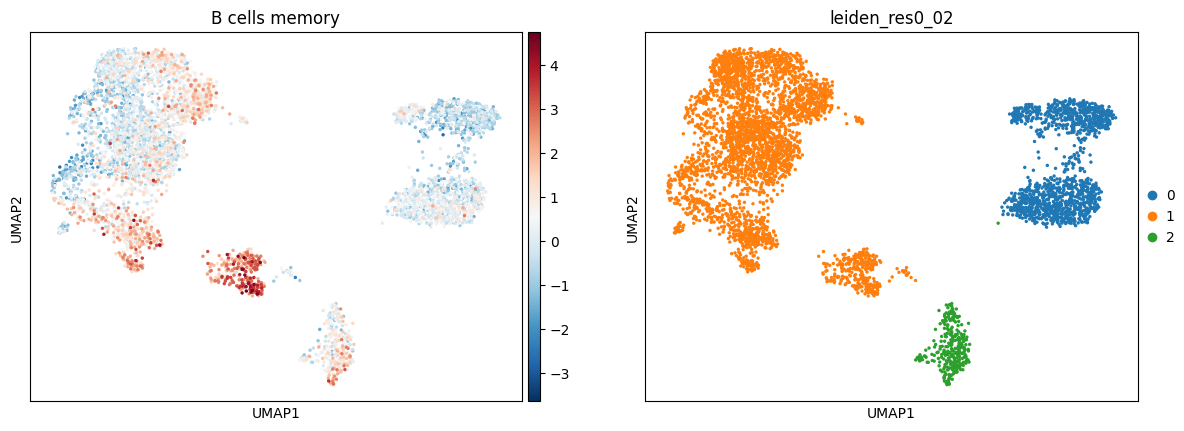

In [58]:
sc.pl.umap(score, color=["B cells memory", "leiden_res0_02"], cmap="RdBu_r")

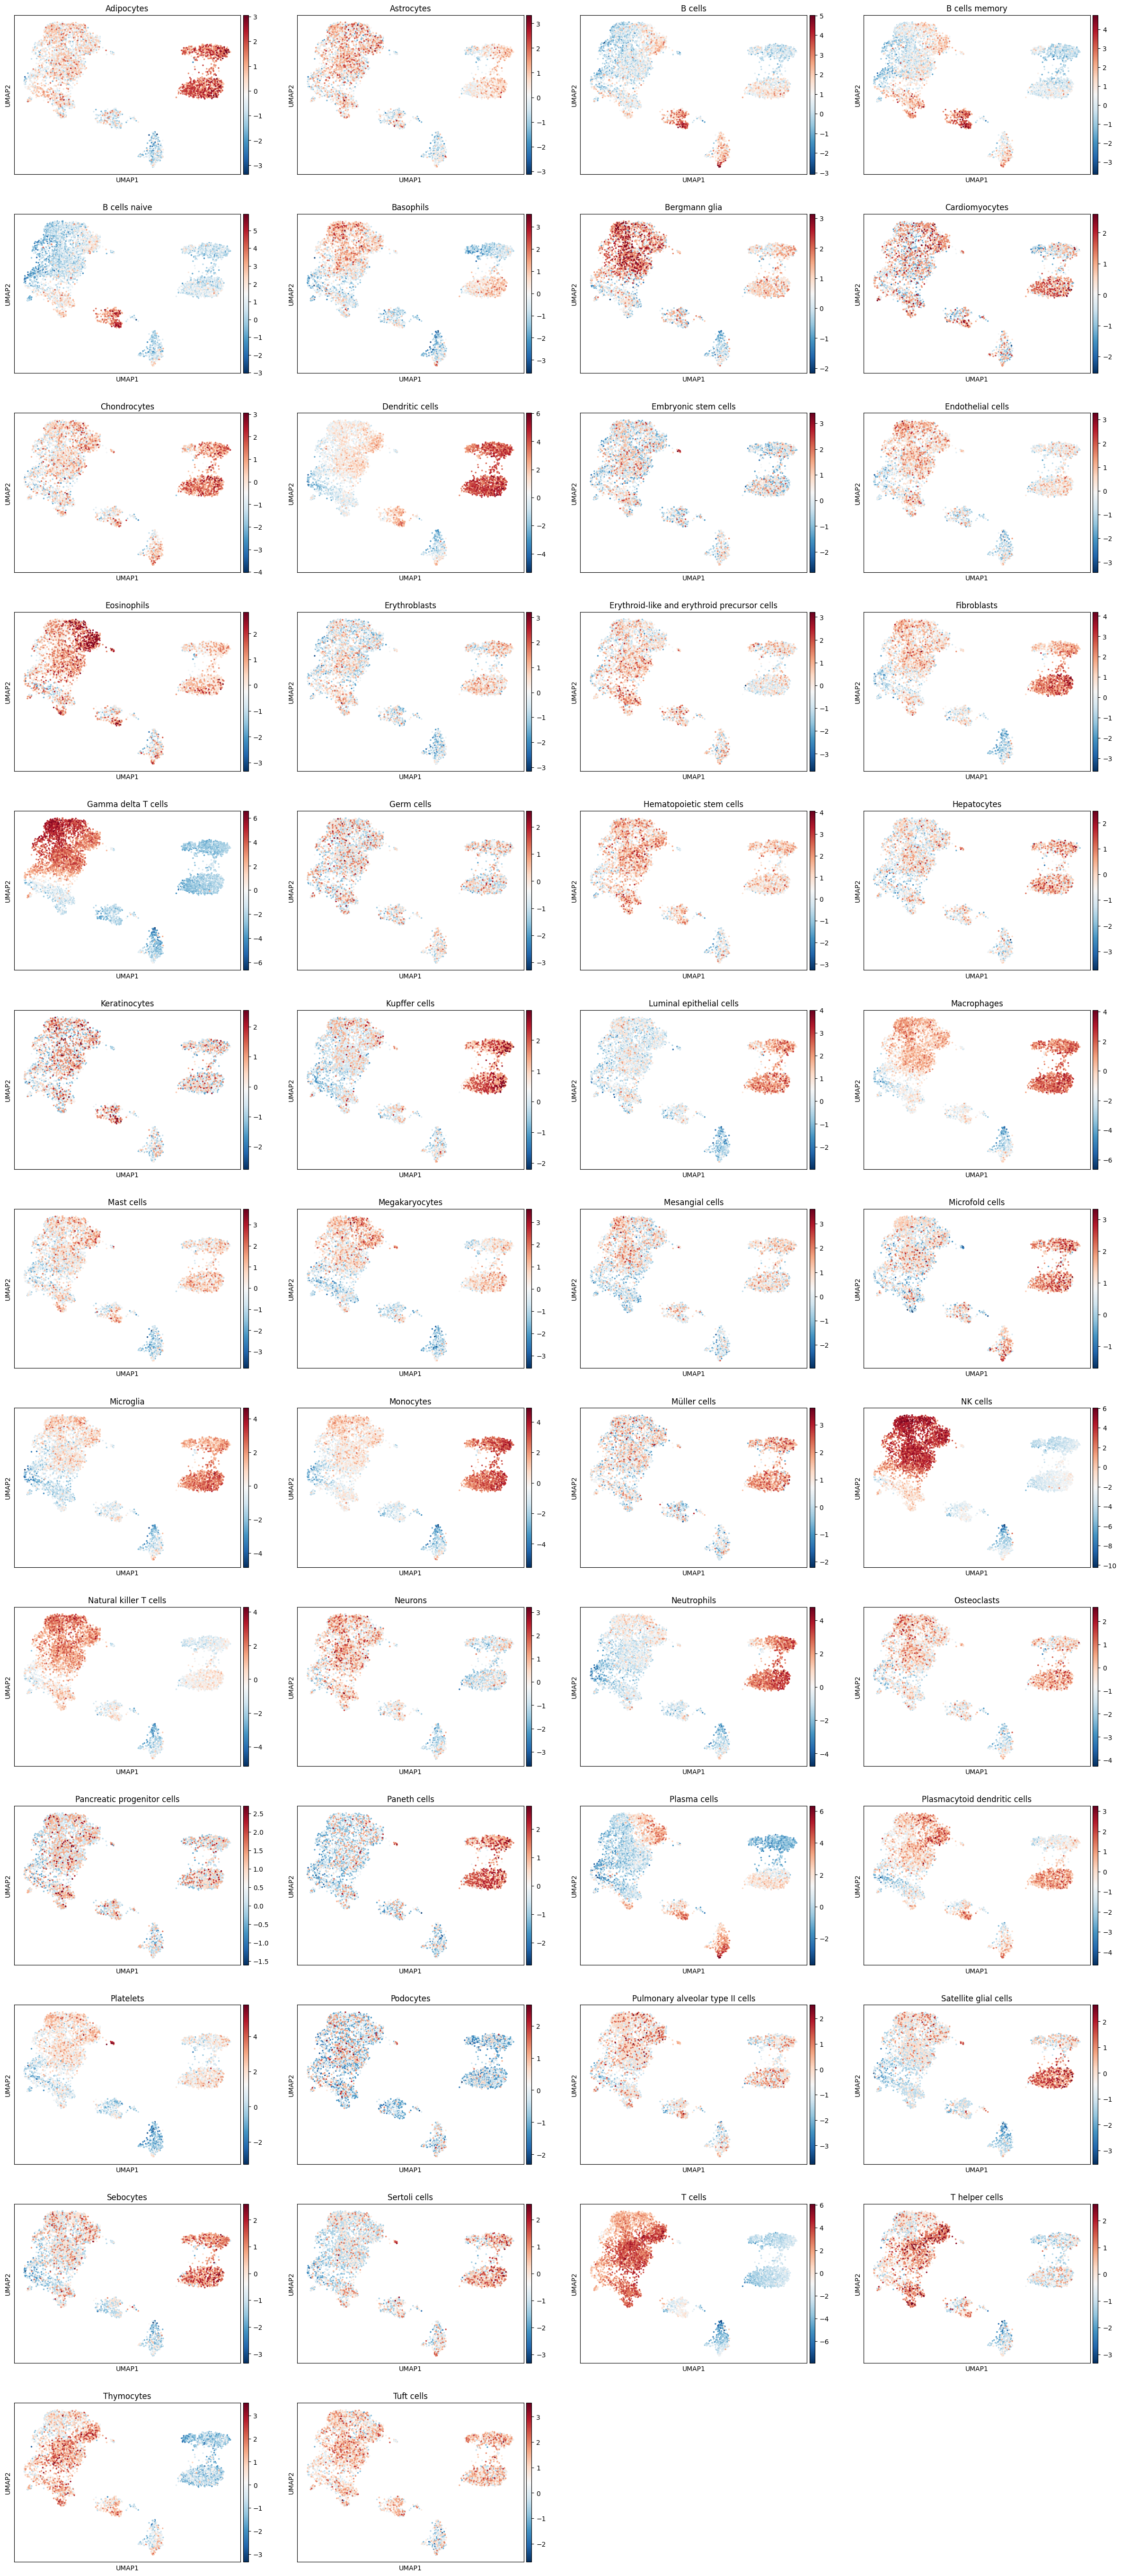

In [81]:
sc.pl.umap(score, color=['Adipocytes', 'Astrocytes', 'B cells', 'B cells memory',
       'B cells naive', 'Basophils', 'Bergmann glia', 'Cardiomyocytes',
       'Chondrocytes', 'Dendritic cells', 'Embryonic stem cells',
       'Endothelial cells', 'Eosinophils', 'Erythroblasts',
       'Erythroid-like and erythroid precursor cells', 'Fibroblasts',
       'Gamma delta T cells', 'Germ cells', 'Hematopoietic stem cells',
       'Hepatocytes', 'Keratinocytes', 'Kupffer cells',
       'Luminal epithelial cells', 'Macrophages', 'Mast cells',
       'Megakaryocytes', 'Mesangial cells', 'Microfold cells', 'Microglia',
       'Monocytes', 'Müller cells', 'NK cells', 'Natural killer T cells',
       'Neurons', 'Neutrophils', 'Osteoclasts', 'Pancreatic progenitor cells',
       'Paneth cells', 'Plasma cells', 'Plasmacytoid dendritic cells',
       'Platelets', 'Podocytes', 'Pulmonary alveolar type II cells',
       'Satellite glial cells', 'Sebocytes', 'Sertoli cells', 'T cells',
       'T helper cells', 'Thymocytes', 'Tuft cells'], cmap="RdBu_r")

In [60]:
import seaborn as sns

2025-11-20 21:58:22 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-20 21:58:22 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-20 21:58:22 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-20 21:58:22 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-20 21:58:22 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

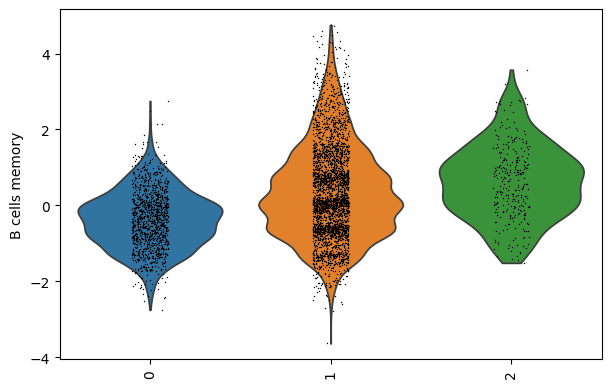

In [61]:
sc.pl.violin(score, keys=["B cells memory"], groupby="leiden_res0_02", rotation=90)

2025-11-20 21:58:22 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-20 21:58:22 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-20 21:58:22 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-20 21:58:22 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-20 21:58:23 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

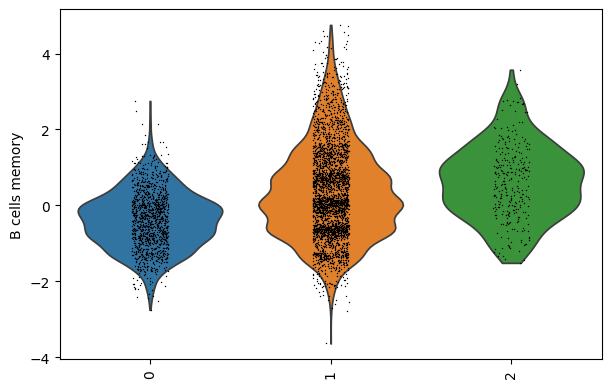

In [62]:
sc.pl.violin(score, keys=["B cells memory"], groupby="leiden_res0_02", rotation=90)

In [63]:
#. Now let's know what each of the 7 clusters mean

In [64]:
#rank genes
adata_rank = dc.tl.rankby_group(score, groupby="leiden_res0_02", reference="rest", method="t-test_overestim_var")
adata_rank = adata_rank[adata_rank["stat"] > 0]
adata_rank.head()

group reference             name       stat  meanchange  pval  padj
0     0      rest  Dendritic cells  90.071198    3.451762   0.0   0.0
1     0      rest      Neutrophils  75.245797    2.889229   0.0   0.0
2     0      rest        Monocytes  74.153533    2.864185   0.0   0.0
3     0      rest    Kupffer cells  58.472725    1.434458   0.0   0.0
4     0      rest        Microglia  57.885156    2.198037   0.0   0.0

In [65]:
cluster_annotations = adata_rank[adata_rank["stat"] > 0].groupby("group").head(1).set_index("group")["name"].to_dict()

/tmp/ipykernel_701/1414602722.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_annotations = adata_rank[adata_rank["stat"] > 0].groupby("group").head(1).set_index("group")["name"].to_dict()


In [66]:
cluster_annotations

{'0': 'Dendritic cells', '1': 'T cells', '2': 'Plasma cells'}

In [67]:
adata.obs['cell_type'] = adata.obs['leiden_res0_02'].map(cluster_annotations)


In [68]:
# Example of how to subset for multiple genes in the 'source' column
available_genes = set(adata.var_names)

b_cell_markers = markers[markers['source'].isin(['B cells memory'])]['target']
b_cell_markers = b_cell_markers[b_cell_markers.isin(available_genes)]

nk_cell_markers = markers[markers['source'].isin(['Natural killer T cells'])]['target']
nk_cell_markers = nk_cell_markers[nk_cell_markers.isin(available_genes)]

t_cells_markers = markers[markers['source'].isin(['T cells'])]['target']
t_cells_markers = t_cells_markers[t_cells_markers.isin(available_genes)]

adipocytes_markers = markers[markers['source'].isin(['Adipocytes'])]['target']
adipocytes_markers = adipocytes_markers[adipocytes_markers.isin(available_genes)]


display(adipocytes_markers)

1796    ENSG00000133106
3565    ENSG00000163563
3626    ENSG00000125148
5922    ENSG00000100300
Name: target, dtype: object

### Other ways to visualize the cell types

In [75]:
marker_genes_dict = {
    "B cells": b_cell_markers.head().tolist(),
    "NK cells": nk_cell_markers.head().tolist(),
    "T cells": t_cells_markers.head().tolist(),
    "Adipocytes": adipocytes_markers.head().tolist()
}

categories: Dendritic cells, T cells, Plasma cells
var_group_labels: B cells, NK cells, T cells, etc.


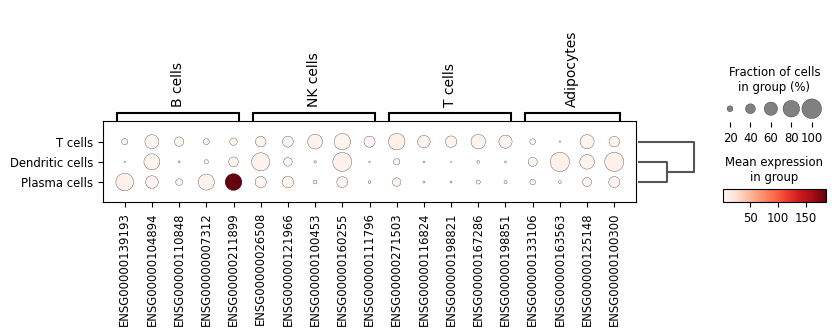

In [76]:
sc.pl.dotplot(adata, marker_genes_dict, groupby="cell_type", dendrogram=True)

categories: 0, 1, 2
var_group_labels: B cells, NK cells, T cells, etc.


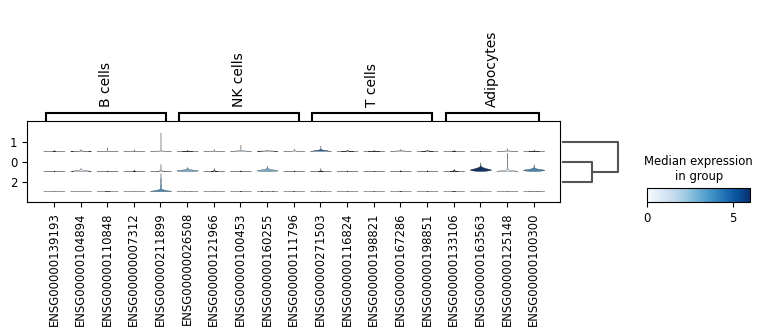

In [77]:
sc.pl.stacked_violin(
    adata, marker_genes_dict, groupby="leiden_res0_02",  dendrogram=True
)

categories: 0, 1, 2
var_group_labels: B cells, NK cells, T cells, etc.


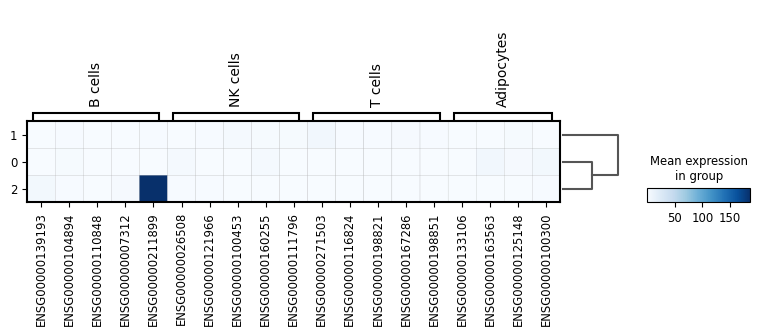

In [78]:
sc.pl.matrixplot(
    adata,
    marker_genes_dict,
    "leiden_res0_02",
    dendrogram=True,
    cmap="Blues",
)

categories: 0, 1, 2
var_group_labels: B cells, NK cells, T cells, etc.


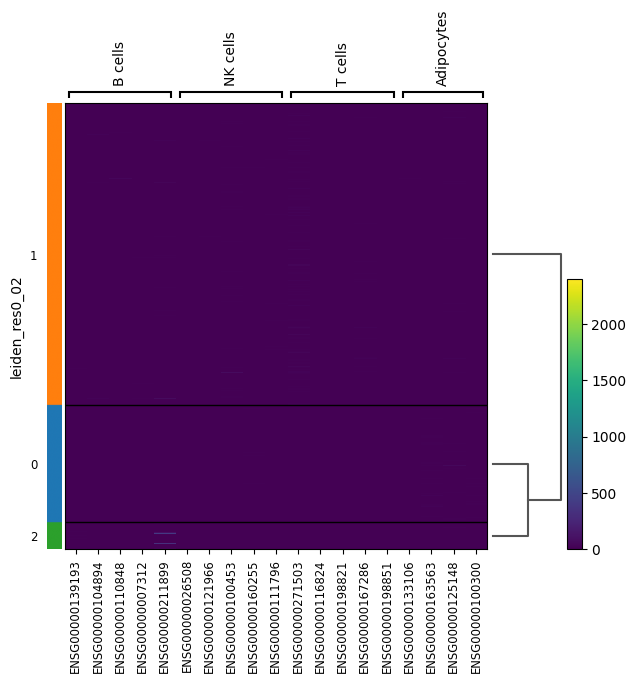

In [79]:
sc.pl.heatmap(
    adata, marker_genes_dict, groupby="leiden_res0_02", cmap="viridis", dendrogram=True
)

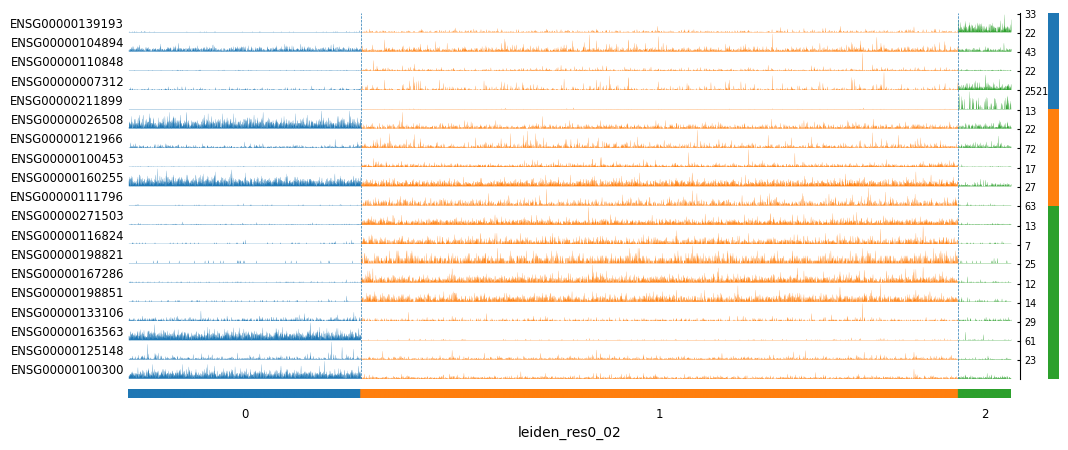

In [80]:
# @title Using genome tracks
sc.pl.tracksplot(adata, marker_genes_dict, groupby="leiden_res0_02", dendrogram=False)